# PREVISÃO DE PREÇOS DE AÇÕES UTILIZANDO LSTM

Este projeto visa à previsão dos preços de fechamento da ação PETR4.SA para os cinco dias úteis subsequentes ao término do histórico disponível, empregando uma rede neural do tipo Long Short-Term Memory (LSTM). Os dados históricos são obtidos através da biblioteca `yfinance` e submetidos a um processo de tratamento para alimentar o modelo de aprendizado profundo, que identifica padrões nas variações dos preços.

In [1]:
# Configurações das variáveis do projeto
stock_symbol = 'PETR4.SA' # Símbolo da ação para análise.
start_date = '2018-01-01' # Data de início para a coleta de dados históricos.
end_date = '2025-06-02'   # Data de término para a coleta de dados históricos.
n_days_to_predict = 5     # Horizonte de previsão.
time_step = 60            # Janela temporal utilizadas como entrada para o modelo LSTM.
test_split_ratio = 0.2    # Proporção do conjunto de dados reservada para teste.
n_neurons = 50            # Neurônios em cada camada LSTM.
dropout_rate = 0.2        # Taxa de dropout aplicada para regularização, visando reduzir overfitting.
n_epochs = 25             # Número de épocas para o treinamento do modelo.
batch_size = 32           # Tamanho do lote utilizado durante o treinamento.

# Importação das dependências do projeto.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# PREVISÃO DE PREÇOS DE AÇÕES UTILIZANDO LSTM

Este projeto tem como objetivo prever os preços de fechamento da ação PETR4.SA para os 5 próximos dias úteis após o fim do histórico disponível, utilizando uma rede neural LSTM. Os dados históricos são obtidos com a biblioteca yfinance e processados para alimentar um modelo de aprendizado profundo, que aprende padrões de variação dos preços. A avaliação do modelo é realizada em um conjunto de teste separado.

## 1. Aquisição e Pré-processamento dos Dados
Esta seção abrange a obtenção dos dados históricos da ação, a seleção da variável alvo (preço de fechamento), a normalização dos dados e a estruturação em janelas temporais adequadas para a entrada no modelo LSTM.

In [2]:
# Download dos dados históricos da ação especificada.
df = yf.download(stock_symbol, start=start_date, end=end_date)
print("Amostra de dados brutos:")
print(df.head())
if df.empty:
    raise ValueError("Nenhum dado baixado. Verifique o símbolo da ação e o período.")

# Seleciona apenas a coluna do preço de fechamento e transforma em um array NumPy bidimensional
data = df['Close'].values.reshape(-1, 1)

# Os dados foram normalizados para o intervalo [0, 1] utilizando MinMaxScaler.
# Ressalta-se que, para evitar data leakage, o ajuste do scaler deveria ser realizado apenas sobre o conjunto de treinamento.
# Neste experimento, optou-se por aplicar o ajuste sobre o conjunto completo para fins de simplificação, o que representa uma limitação metodológica.
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Função para criar as janelas de tempo
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0]) # Sequência de entrada.
        y.append(dataset[i, 0])             # Valor alvo.
    return np.array(X), np.array(y)

# Cria os datasets de entrada e saída a partir de todo o histórico normalizado
X_full, y_full = create_dataset(data_scaled, time_step)

# Redimensiona X_full para o formato esperado pela LSTM, uma entrada 3D
X_full = X_full.reshape(X_full.shape[0], X_full.shape[1], 1)

print(f"\nFormato de X_full (antes da divisão): {X_full.shape}") # Formato esperado: (número_amostras, time_step, 1_feature)
print(f"Formato de y_full (antes da divisão): {y_full.shape}") # Formato esperado: (número_amostras,)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Amostra de dados brutos:
Price          Close      High       Low      Open    Volume
Ticker      PETR4.SA  PETR4.SA  PETR4.SA  PETR4.SA  PETR4.SA
Date                                                        
2018-01-02  4.830965  4.830965  4.725881  4.725881  33461800
2018-01-03  4.874750  4.880587  4.778422  4.813450  55940900
2018-01-04  4.883508  4.950645  4.851399  4.898103  37064900
2018-01-05  4.912697  4.921455  4.836803  4.874750  26958200
2018-01-08  4.971077  4.971077  4.877668  4.886425  28400000

Formato de X_full (antes da divisão): (1780, 60, 1)
Formato de y_full (antes da divisão): (1780,)


## 2. Divisão dos Dados em Conjunto de Treinamento e Teste
Os dados são divididos cronologicamente para assegurar que a avaliação do modelo seja realizada em dados futuros, não visualizados durante a fase de treinamento.

In [3]:
# Cálculo do índice para a divisão cronológica dos dados em conjuntos de treinamento e teste.
train_size = int(len(X_full) * (1 - test_split_ratio))

# Divide X e y em conjuntos de treino e teste
X_train, X_test = X_full[0:train_size], X_full[train_size:len(X_full)]
y_train, y_test = y_full[0:train_size], y_full[train_size:len(y_full)] # y_test permanece normalizado nesta etapa.

print(f"\nFormato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_test: {y_test.shape}")

# Timestamps para o conjunto de teste para apresentação
# O índice inicial `start_index_for_test_plot` considera o `time_step` para alinhar com `y_test`,
# pois as primeiras `time_step` amostras de `data_scaled` são usadas para compor a primeira entrada de `X_full`,
# e `y_full[0]` corresponde a `data_scaled[time_step]`.
start_index_for_test_plot = train_size + time_step
# Garante que o slice de timestamps tenha o mesmo tamanho que y_test.
test_timestamps = df.index[start_index_for_test_plot : start_index_for_test_plot + len(y_test)]


Formato de X_train: (1424, 60, 1)
Formato de y_train: (1424,)
Formato de X_test: (356, 60, 1)
Formato de y_test: (356,)


## 3. Construção e Treinamento do Modelo LSTM
Definição da arquitetura da rede neural, composta por camadas LSTM, camadas de Dropout para regularização e uma camada Densa final para a previsão do preço. O modelo é, então, treinado com o conjunto de treinamento.

In [4]:
# Definição da arquitetura do modelo LSTM sequencial.
model = Sequential()
# Adiciona a primeira camada LSTM com retorno das sequências
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(time_step, 1)))
# Camada Dropout para regularização, visando mitigar o overfitting.
model.add(Dropout(dropout_rate))
# Segunda camada LSTM. `return_sequences=False` por padrão, pois é a última camada recorrente antes da camada densa de saída.
model.add(LSTM(n_neurons))
# Camada Dropout adicional para regularização.
model.add(Dropout(dropout_rate))
# Camada Densa de saída com um neurônio para prever o valor do próximo dia (regressão).
model.add(Dense(1))

# Compilação do modelo, utilizando o otimizador 'adam' e a função de perda 'mean_squared_error' (MSE).
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary() # Informações sobre o treinamento

# Treinamento do modelo utilizando os dados de treinamento.
print("\nIniciando o treinamento do modelo...")
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test), # Avaliação no conjunto de teste ao final de cada época.
                    verbose=1,
                    shuffle=False) # Desabilita-se o embaralhamento para dados de séries temporais.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento do modelo...
Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0158 - val_loss: 0.0022
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 8.5726e-04 - val_loss: 0.0013
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 5.3312e-04 - val_loss: 0.0013
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 9/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 5.4703e-04 - val_loss: 0.0011
Epoch 11/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 12/25
4

## 4. Avaliação do Modelo no Conjunto de Teste
O modelo treinado é utilizado para gerar previsões sobre o conjunto de teste. Estas previsões são, então, comparadas com os valores reais para o cálculo de métricas de erro.

In [5]:
# Realização de previsões sobre o conjunto de teste. As previsões estão na escala normalizada.
test_predictions_scaled = model.predict(X_test)

# Reversão da normalização (desnormalização) das previsões e dos valores reais do conjunto de teste
# para a escala original dos preços.
real_test_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_test_prices = scaler.inverse_transform(test_predictions_scaled)

# Cálculo das métricas de erro para avaliar o desempenho do modelo no conjunto de teste.
# Estas métricas quantificam a discrepância entre os preços reais (`real_test_prices`)
# e os preços previstos pelo modelo (`predicted_test_prices`).

# 1. Erro Quadrático Médio (Mean Squared Error - MSE), a média dos quadrados das diferenças entre os valores previstos e os valores reais.
mse_test = mean_squared_error(real_test_prices, predicted_test_prices)

# 2. Raiz do Erro Quadrático Médio, representa o desvio padrão dos erros de previsão:
rmse_test = sqrt(mse_test)

# 3. Erro Absoluto Médio (Mean Absolute Error - MAE):
# O MAE é calculado como a média dos valores absolutos das diferenças entre os valores previstos e os reais.
mae_test = mean_absolute_error(real_test_prices, predicted_test_prices)

print(f"\n--- Resultados da Avaliação no Conjunto de Teste ---")
print(f"Erro Quadrático Médio (MSE) no teste: {mse_test:.4f}")
print(f"Raiz do Erro Quadrático Médio (RMSE) no teste: R$ {rmse_test:.2f}")
print(f"Erro Absoluto Médio (MAE) no teste: R$ {mae_test:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

--- Resultados da Avaliação no Conjunto de Teste ---
Erro Quadrático Médio (MSE) no teste: 1.0931
Raiz do Erro Quadrático Médio (RMSE) no teste: R$ 1.05
Erro Absoluto Médio (MAE) no teste: R$ 0.84


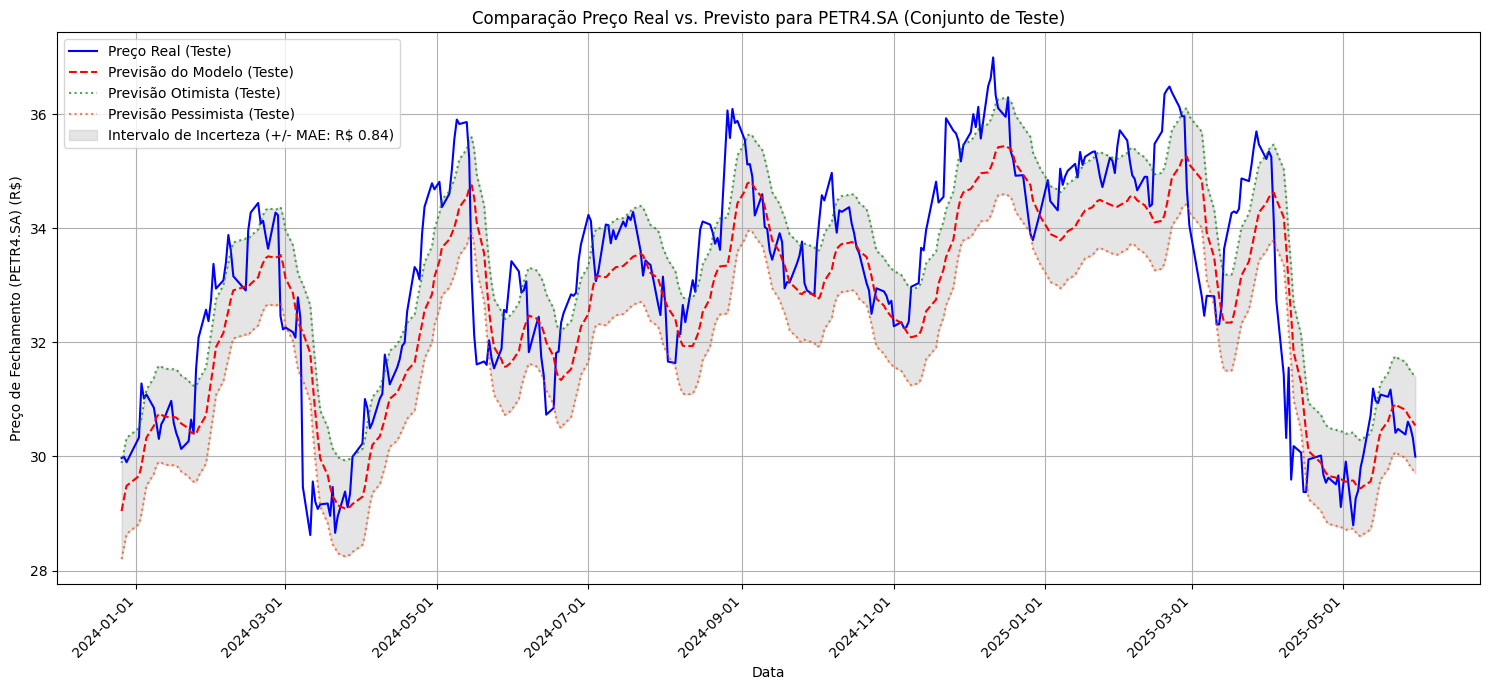

In [6]:
# Visualização gráfica comparando os preços reais do conjunto de teste com as previsões do modelo.
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(test_timestamps, real_test_prices, color='blue', label='Preço Real (Teste)')
ax.plot(test_timestamps, predicted_test_prices, color='red', linestyle='--', label='Previsão do Modelo (Teste)')

# Inclusão de bandas de previsão otimista e pessimista, baseadas no MAE, no gráfico do conjunto de teste.
predicted_test_optimistic = predicted_test_prices + mae_test
predicted_test_pessimistic = predicted_test_prices - mae_test
predicted_test_pessimistic = np.maximum(0, predicted_test_pessimistic) # Garante que os preços não sejam negativos.

ax.plot(test_timestamps, predicted_test_optimistic, color='green', linestyle=':', alpha=0.7, label='Previsão Otimista (Teste)')
ax.plot(test_timestamps, predicted_test_pessimistic, color='orangered', linestyle=':', alpha=0.7, label='Previsão Pessimista (Teste)')
ax.fill_between(test_timestamps,
                 predicted_test_pessimistic.flatten(),
                 predicted_test_optimistic.flatten(),
                 color='gray', alpha=0.2, label=f'Intervalo de Incerteza (+/- MAE: R$ {mae_test:.2f})')

ax.set_title(f'Comparação Preço Real vs. Previsto para {stock_symbol} (Conjunto de Teste)')
# Verifica se os timestamps correspondem aos dados para rotular o eixo X corretamente.
ax.set_xlabel('Data' if len(test_timestamps) == len(real_test_prices) else 'Índice do Período de Teste')
ax.set_ylabel(f'Preço de Fechamento ({stock_symbol}) (R$)')
ax.legend()
ax.grid(True)
# Formatação das datas no eixo X.
if len(test_timestamps) == len(real_test_prices):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Ajusta o layout para evitar sobreposição de elementos.
plt.show()

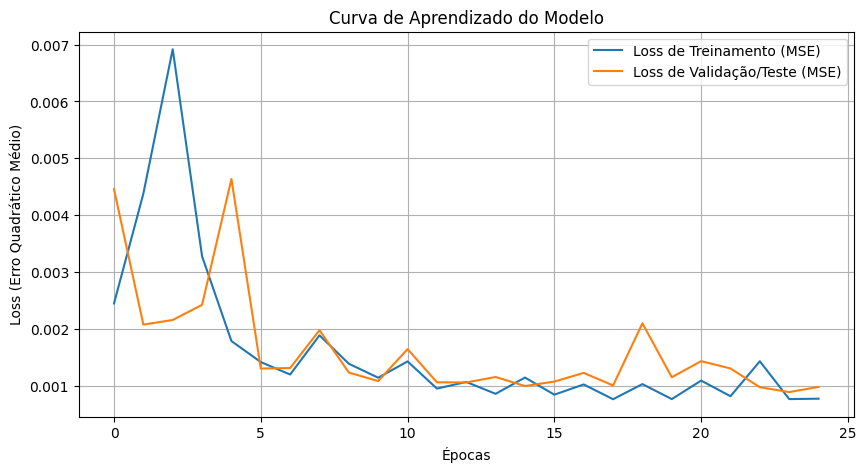

In [7]:
# Visualização da curva de aprendizado, mostrando o erro (loss) de treinamento e validação por época.
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Loss de Treinamento (MSE)')
plt.plot(history.history['val_loss'], label='Loss de Validação/Teste (MSE)')
plt.title('Curva de Aprendizado do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss (Erro Quadrático Médio)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Previsão dos Próximos N Dias Úteis com Cenários Otimista e Pessimista
Utilização da última sequência de `time_step` dias reais do histórico completo (normalizado) para gerar previsões futuras de forma recursiva. Os cenários otimista e pessimista são derivados do Erro Absoluto Médio calculado no conjunto de teste.


--- Previsão para os Próximos Dias (com cenários) ---
Previsão para os próximos 5 dias úteis (após 2025-05-30):
Usando MAE de R$ 0.84 para cenários otimista/pessimista.
Data: 2025-06-02, Pessimista: R$ 29.60, Previsto: R$ 30.44, Otimista: R$ 31.28
Data: 2025-06-03, Pessimista: R$ 29.55, Previsto: R$ 30.39, Otimista: R$ 31.23
Data: 2025-06-04, Pessimista: R$ 29.51, Previsto: R$ 30.35, Otimista: R$ 31.20
Data: 2025-06-05, Pessimista: R$ 29.49, Previsto: R$ 30.33, Otimista: R$ 31.17
Data: 2025-06-06, Pessimista: R$ 29.48, Previsto: R$ 30.32, Otimista: R$ 31.16


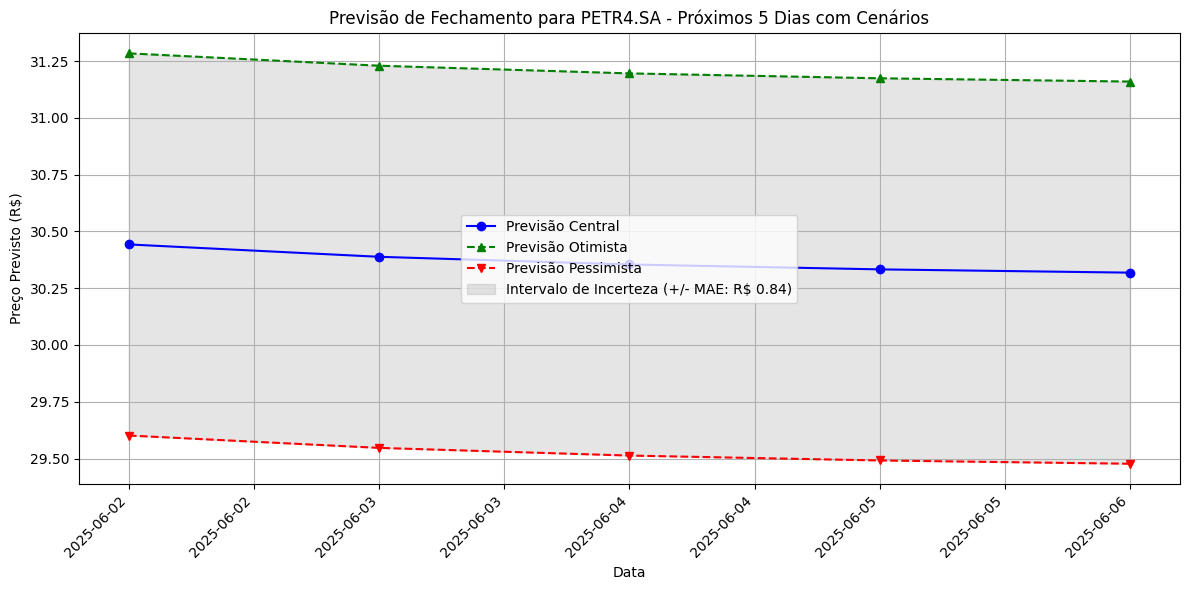

In [8]:
print("\n--- Previsão para os Próximos Dias (com cenários) ---")
# Utilização da última sequência de `time_step` dias do conjunto de dados completo (`data_scaled`, normalizado)
# como entrada inicial para a previsão futura.
last_sequence_scaled = data_scaled[-time_step:].reshape(1, time_step, 1)

# Geração iterativa de previsões para os próximos `n_days_to_predict` dias úteis.
predicted_future_scaled_list = []
current_sequence = last_sequence_scaled.copy() # Cópia para evitar modificação da sequência original.

for _ in range(n_days_to_predict):
    # Previsão do próximo valor (normalizado) utilizando a sequência atual.
    next_price_scaled_pred = model.predict(current_sequence, verbose=0)[0][0]
    # Armazenamento da previsão normalizada.
    predicted_future_scaled_list.append(next_price_scaled_pred)
    # Atualização da sequência de entrada: o valor mais antigo é removido e a nova previsão (normalizada) é adicionada ao final, mantendo o formato [1, time_step, 1].
    new_element_scaled = np.array([[[next_price_scaled_pred]]])
    current_sequence = np.append(current_sequence[:, 1:, :], new_element_scaled, axis=1)

# Desnormalização das previsões futuras (lista de escalares normalizados) para a escala original dos preços.
predicted_future_prices = scaler.inverse_transform(np.array(predicted_future_scaled_list).reshape(-1, 1))

# Cálculo dos cenários otimista e pessimista para as previsões futuras,
# utilizando o MAE (na escala original do preço) obtido no conjunto de teste.
optimistic_future_prices = predicted_future_prices + mae_test
pessimistic_future_prices = predicted_future_prices - mae_test
# Garante que o preço no cenário pessimista não seja negativo.
pessimistic_future_prices = np.maximum(0, pessimistic_future_prices)


# Exibe os valores previstos para os próximos N dias
last_real_date = df.index[-1]
print(f"Previsão para os próximos {n_days_to_predict} dias úteis (após {last_real_date.strftime('%Y-%m-%d')}):")
print(f"Usando MAE de R$ {mae_test:.2f} para cenários otimista/pessimista.")

# Geração das datas futuras correspondentes às previsões, considerando apenas dias úteis.
future_dates = pd.date_range(start=last_real_date + pd.Timedelta(days=1),
                             periods=n_days_to_predict,
                             freq='B') # 'B' para Business day frequency

for i in range(n_days_to_predict):
    print(f"Data: {future_dates[i].strftime('%Y-%m-%d')}, "
          f"Pessimista: R$ {pessimistic_future_prices[i][0]:.2f}, "
          f"Previsto: R$ {predicted_future_prices[i][0]:.2f}, "
          f"Otimista: R$ {optimistic_future_prices[i][0]:.2f}")

# Visualização gráfica das previsões futuras, incluindo os cenários otimista e pessimista e o intervalo de incerteza.
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(future_dates, predicted_future_prices, marker='o', linestyle='-', color='blue', label=f'Previsão Central')
ax.plot(future_dates, optimistic_future_prices, marker='^', linestyle='--', color='green', label='Previsão Otimista')
ax.plot(future_dates, pessimistic_future_prices, marker='v', linestyle='--', color='red', label='Previsão Pessimista')

# Adição da banda de incerteza ao gráfico.
ax.fill_between(future_dates,
                 pessimistic_future_prices.flatten(),
                 optimistic_future_prices.flatten(),
                 color='gray', alpha=0.2, label=f'Intervalo de Incerteza (+/- MAE: R$ {mae_test:.2f})')

ax.set_title(f'Previsão de Fechamento para {stock_symbol} - Próximos {n_days_to_predict} Dias com Cenários')
ax.set_xlabel('Data')
ax.set_ylabel('Preço Previsto (R$)')
ax.legend()
ax.grid(True)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Análise do Erro Absoluto no Conjunto de Teste
Visualização da magnitude do erro em cada ponto do conjunto de teste.

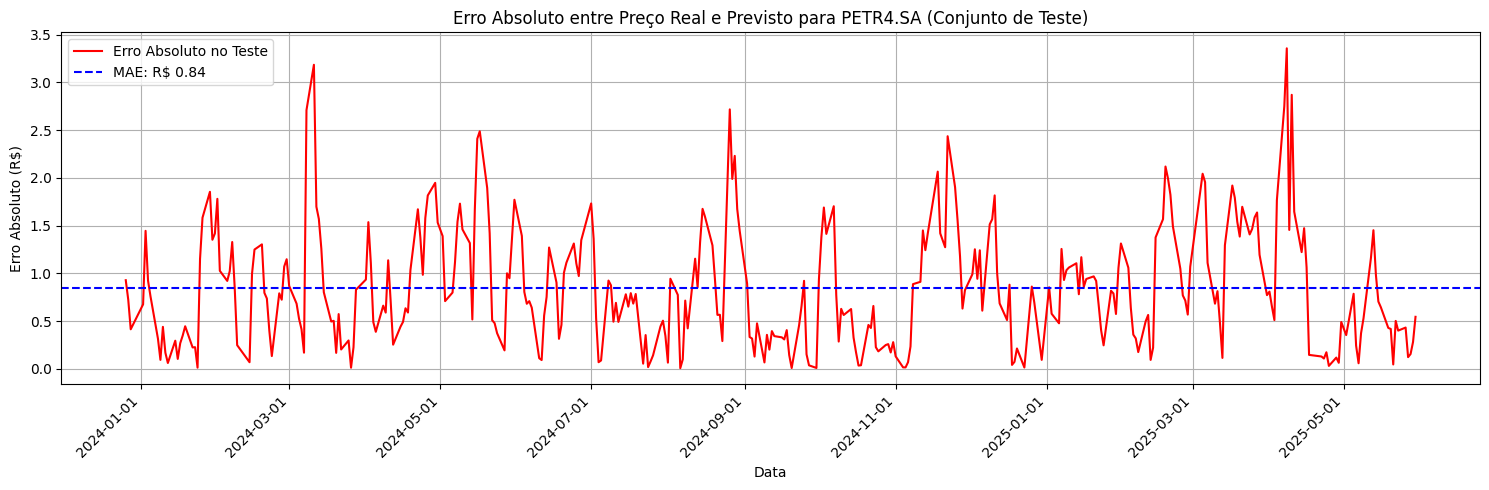


Erro Absoluto Médio (MAE) no teste (verificação por cálculo manual): R$ 0.84


In [9]:
# Cálculo do erro absoluto em cada ponto do conjunto de teste.
erro_absoluto_teste = np.abs(real_test_prices - predicted_test_prices)

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_timestamps, erro_absoluto_teste, color='red', label='Erro Absoluto no Teste')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Formatação das datas no eixo X.
plt.xticks(rotation=45, ha='right')

ax.set_title(f'Erro Absoluto entre Preço Real e Previsto para {stock_symbol} (Conjunto de Teste)')
ax.set_xlabel('Data' if len(test_timestamps) == len(erro_absoluto_teste) else 'Índice do Período de Teste')
ax.set_ylabel('Erro Absoluto (R$)')
# Adição de uma linha horizontal representando o MAE para referência visual.
ax.axhline(y=mae_test, color='blue', linestyle='--', label=f'MAE: R$ {mae_test:.2f}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

print(f"\nErro Absoluto Médio (MAE) no teste (verificação por cálculo manual): R$ {np.mean(erro_absoluto_teste):.2f}")